# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 1. Полносвязные нейронные сети. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить полносвязную нейронную сеть для предсказания года выпуска песни по ее аудио-признакам. Для этого мы будем использовать [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import clear_output

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

## При использовании GPU время выполнения растет, вероятно,
## из-за большого количества операций переноса в память GPU
# device = torch.device('cuda:0')
device = torch.device('cpu')

plt.rcParams.update({"font.size": 16})
sns.set_style("whitegrid")
np.random.seed(0xFA1AFE1)

Начнем с того, что скачаем и загрузим данные:

In [ ]:
## Переписал для windows
# !mkdir data 2>nul
# !curl -L -o data\data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [3]:
df = pd.read_csv("data\data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Посмотрим на статистики по данным.

In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


Целевая переменная, год выпуска песни, записана в первом столбце. Посмотрим на ее распределение.

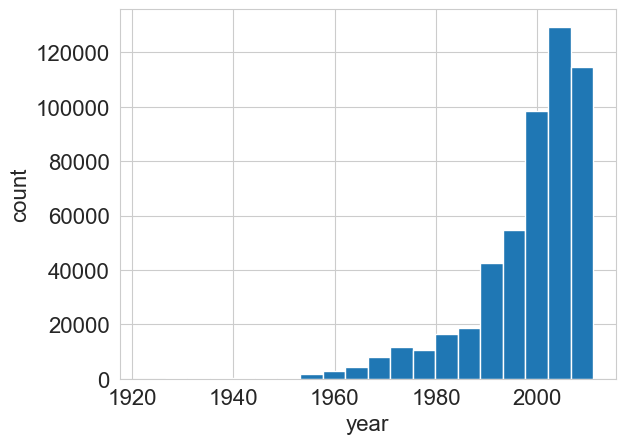

Range: 1922 - 2011
Unique values: 89


In [5]:
plt.hist(df.iloc[:, 0], bins=20)
plt.xlabel("year")
plt.ylabel("count")
plt.show()

print(f"Range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}")
print(f"Unique values: {np.unique(df.iloc[:, 0]).size}")

Разобьем данные на обучение и тест (не меняйте здесь ничего, чтобы сплит был одинаковым у всех).

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = int(0.75 * X.shape[0])
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
X_train.shape, X_test.shape

((386508, 90), (128837, 90))

**Задание 0 (0 баллов, но при невыполнении максимальная оценка за всю работу &mdash; 0 баллов).** Мы будем использовать MSE как метрику качества. Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы. Для этого бучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе (также пропишите текстом, какая константа будет лучшей для MSE).

In [7]:
baseline_ridge_param_grid = {
    "alpha": np.linspace(3800, 4100, 10)
}

baseline_ridge = Ridge()

baseline_ridge_gscv = GridSearchCV(
    estimator=baseline_ridge,
    param_grid=baseline_ridge_param_grid,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    verbose=3
)

baseline_ridge_gscv = baseline_ridge_gscv.fit(X_train, y_train)
print(f"Best alpha: {baseline_ridge_gscv.best_params_['alpha']:.3f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha: 3866.667


In [8]:
baseline_ridge_mse = mean_squared_error(baseline_ridge_gscv.predict(X_test), y_test)
print(f"MSE (Baseline Ridge): {baseline_ridge_mse:.3f}")

MSE (Baseline Ridge): 89.750


In [9]:
# Если мы считаем метрику MSE, то лучший константный прогноз - среднее

naive_mse = mean_squared_error(y_train.mean().repeat(y_test.size), y_test)
print(f"MSE (Naive): {naive_mse:.3f}")

MSE (Naive): 117.626


In [10]:
print(f"Лучшая константа (среднее значение таргета по train): {y_train.mean():.3f}")

Лучшая константа (среднее значение таргета по train): 1998.375


> **Ответ:** 1998.375

Теперь приступим к экспериментам с нейросетями. Для начала отделим от данных валидацию:

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=0xE2E4
)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

## Глава I. Заводим нейронную сеть (5 баллов)

**Задание 1.1 (0.5 баллов).** Заполните пропуски в функции `train_and_validate`. Она поможет нам запускать эксперименты. Можете также реализовать поддержку обучения на GPU, чтобы эксперименты считались быстрее. Бесплатно воспользоваться GPU можно на сервисах **Google Colab** и **Kaggle**.

In [12]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 100:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 100:
        axs[1].set_yscale("log")    # Тут было axs[0]

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("MSE")
    plt.show()
    plt.close(fig)

In [13]:
def train_and_validate(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()                
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                metric_value = metric(predictions, y_batch)
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

**Задание 1.2 (0.75 балла).** Попробуем обучить нашу первую нейронную сеть. Здесь целевая переменная дискретная &mdash; это год выпуска песни. Поэтому будем учить сеть на классификацию c помощью [кросс-энтропийной функции потерь](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

- В качестве архитектуры сети возьмите два линейных слоя с активацией ReLU между ними c числом скрытых нейронов, равным 128.
- Используйте SGD с `lr=1e-2`.
- Возьмите размер мини-батча около 32-64, примерно 3-4 эпох обучения должно быть достаточно.
- Скорее всего вам пригодится `torch.utils.data.TensorDataset`. Когда будете конвертировать numpy-массивы в torch-тензоры, используйте тип `torch.float32`.
- Также преобразуйте целевую переменную так, чтобы ее значения принимали значения от $0$ до $C-1$, где $C$ &mdash; число классов (лучше передайте преобразованное значение в TensorDataset, исходное нам еще пригодится)
- В качестве параметра `metric` в `train_and_validate` передайте lambda-выражение, которое считает MSE по выходу нейронной сети и целевой переменной. В случае классификации предсказывается класс с наибольшей вероятностью (или, что то же самое, с наибольшим значением **логита**$^1$).

$^1$ **Логит** &mdash; выход последнего линейного слоя, может принимать любые вещественные значения. Если применить Softmax к логитам, то получатся вероятности распределения классов.

In [14]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

y_train_coded = LE.fit_transform(y_train)
y_val_coded = LE.transform(y_val)
y_test_coded = LE.transform(y_test)

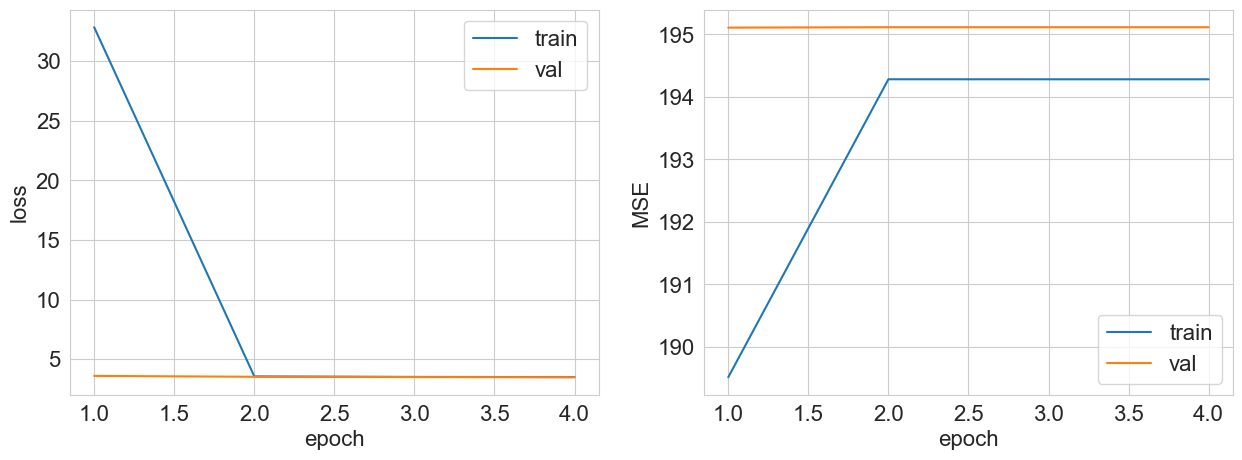

Validation MSE: 195.115


(194.28204332101436, 195.1154853197592)

In [15]:
class InitialModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=128)
        self.af1 = nn.ReLU()
        self.l2 = nn.LazyLinear(out_features=89)

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.af1(pred)
        pred = self.l2(pred)

        return pred

model = InitialModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_coded, dtype=torch.long),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val_coded, dtype=torch.long),
), batch_size=32)


train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=nn.CrossEntropyLoss(),
    metric=lambda x, y: torch.mean(torch.square(torch.argmax(x, dim=1).float() - y.float())),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=4
)

In [16]:
def get_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_coded, dtype=torch.long)
), batch_size=32)

predictions, true_labels = get_predictions(model, test_dataloader)

In [17]:
print(f"Ошибка на test: {mean_squared_error(predictions, true_labels):.3f}")

Ошибка на test: 190.512


In [18]:
print(f"Уникальных годов среди pred: {np.unique(predictions).size}, и real: {np.unique(true_labels).size}")

Уникальных годов среди pred: 1, и real: 84


**Задание 1.3 (0.5 балла).** Прокомментируйте ваши наблюдения. Удалось ли побить бейзлайн? Как вы думаете, хорошая ли идея учить классификатор для этой задачи? Почему?

> **Ответ:** Baseline побить не удалось, ошибка на тестовой выборке больше, чем была. Классификатор для данной задачи не подходит: слишком много различных значений, лучше рассматривать это как задачу регрессии.

**Задание 1.4 (0.75 балла).** Теперь попробуем решать задачу как регрессию. Обучите нейронную сеть на [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

- Используйте такие же гиперпараметры обучения.
- Когда передаете целевую переменную в TensorDataset, сделайте reshape в (-1, 1).
- Не забудьте изменить lambda-выражение, которые вы передаете в `train_and_validate`.
- Если что-то пойдет не так, можете попробовать меньшие значения `lr`.

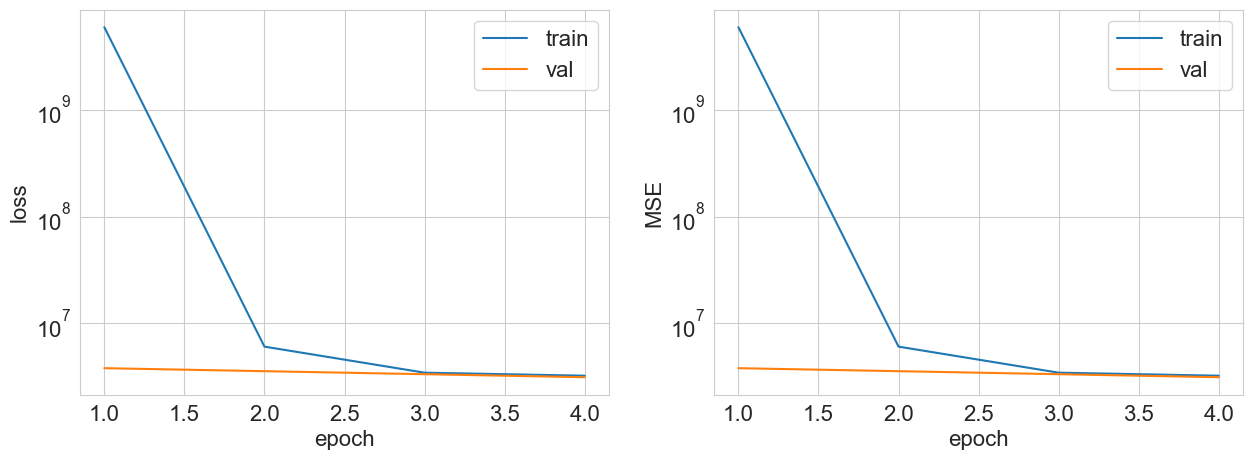

Validation MSE: 3133839.530


(3238280.2264946653, 3133839.530113219)

In [19]:
class InitialModel_MSE(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=128)
        self.af1 = nn.ReLU()
        self.l2 = nn.LazyLinear(out_features=1)

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.af1(pred)
        pred = self.l2(pred)

        return pred

model = InitialModel_MSE()
optimizer = torch.optim.SGD(model.parameters(), lr=1.8e-6, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=4
)

**Задание 1.5 (0.5 балла).** Получилось ли у вас стабилизировать обучение? Помогли ли меньшие значения `lr`? Стало ли лучше от замены классификации на регрессию? Как вы думаете, почему так происходит? В качестве подсказки можете посмотреть на распределение целевой переменной и магнитуду значений признаков.

> **Ответ:** Стабилизировать обучение не получилось, хотя малые значения lr помогли избежать `nan` в MSE. Поскольку мы используем обычный SGD, если масштабы признаков сильно отличаются, то процесс может не сойтись - это в нашем случае и происходит. Кроме того, градиент получается довольно большим и все разваливается.

**Задание 1.6 (0.75 балла).** Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1. Реализуйте функции `normalize` и `denormalize`, которые, соответственно, нормируют целевую переменную и применяют обратное преобразование. Минимум и максимум оцените по обучающей выборке (то есть эти константы должны быть фиксированными и не зависеть от передаваемой выборки).

In [20]:
min_train = torch.tensor(y_train.min(), dtype=torch.float32, device=device)
max_train = torch.tensor(y_train.max(), dtype=torch.float32, device=device)

def normalize(sample: torch.Tensor) -> torch.Tensor:
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return (sample - min_train) / (max_train - min_train)


def denormalize(sample: torch.Tensor) -> torch.Tensor:
    """
    Denormalize sample from [0, 1] to initial range
    """
    return sample * (max_train - min_train) + min_train

Теперь повторите эксперимент из **задания 1.4**, обучаясь на нормированной целевой переменной. Сделаем также еще одно изменение: добавим [сигмоидную активацию](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) после последнего линейного слоя сети. Таким образом мы гарантируем, что нейронная сеть предсказывает числа из промежутка $[0, 1]$. Использование активации - довольно распространенный прием, когда мы хотим получить числа из определенного диапазона значений. 

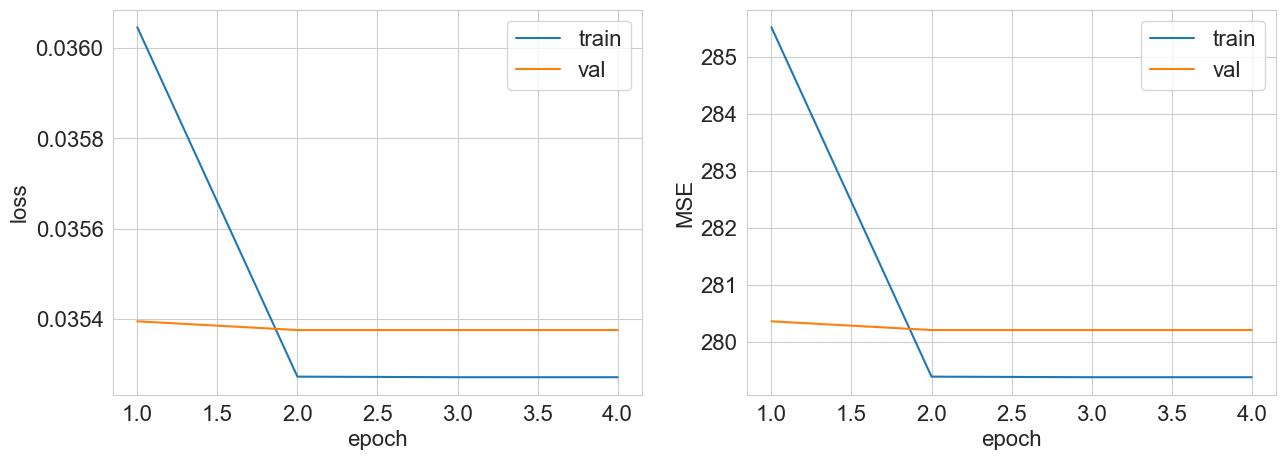

Validation MSE: 280.213


(279.38593971023226, 280.21265381412707)

In [21]:
def train_and_validate_norm(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch_norm = normalize(y_batch)

            predictions: torch.Tensor = model(X_batch)
            loss = criterion(predictions, y_batch_norm)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                metric_value = metric(denormalize(predictions), y_batch)    # Хочу смотреть метрику на исходных данных,
                                                                            # мб лучше было завести отдельный dataloader...
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()                
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch_norm = normalize(y_batch)
            
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch_norm)
                metric_value = metric(denormalize(predictions), y_batch)
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

class InitialModel_MSE_norm(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=128)
        self.af1 = nn.ReLU()
        self.l2 = nn.LazyLinear(out_features=1)
        self.af2 = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.af1(pred)
        pred = self.l2(pred)
        pred = self.af2(pred)

        return pred

model = InitialModel_MSE_norm()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=lambda x, y: torch.mean((x - y)**2),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=4
)

**Задание 1.7 (0.5 балла).** Сравните результаты этого эксперимента с предыдущим запуском. 

> **Ответ:** Процесс обучения улучшился в плане значений MSE, но из-за разного масштаба признаков, градиент не может нормально распространяться

**Задание 1.8 (0.75 балла).** На этот раз попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение. Преобразуйте данные и повторите прошлый эксперимент. Скорее всего, имеет смысл увеличить число эпох обучения.

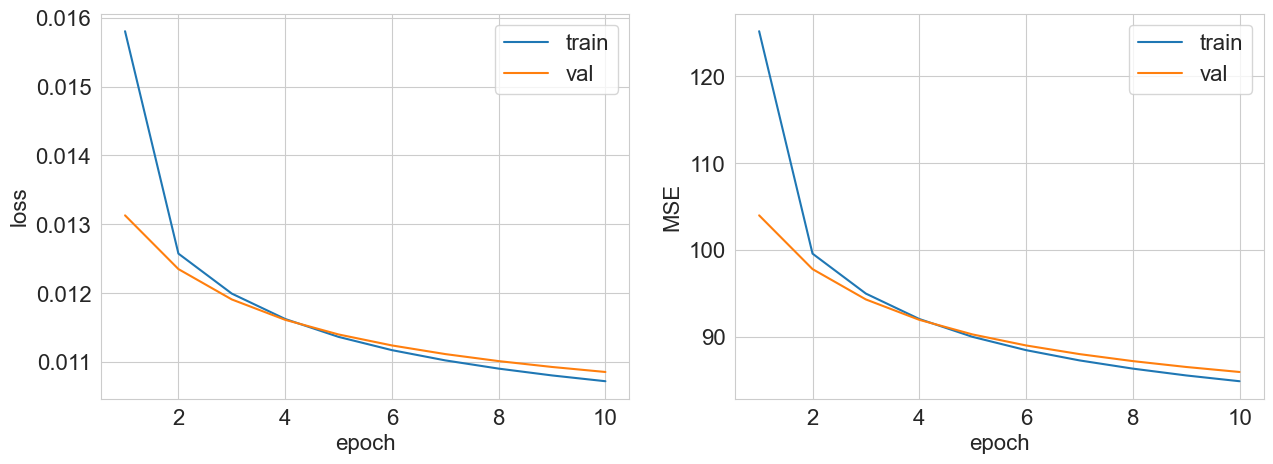

Validation MSE: 85.989


(84.92664246578536, 85.98942262106567)

In [23]:
model = InitialModel_MSE_norm()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, fused=True)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10
)

In [24]:
def get_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predicted = model(X_batch)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
), batch_size=32)

pred, real = get_predictions(model, test_dataloader)

In [25]:
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f} vs Ridge: {baseline_ridge_mse:.3f}")

MSE: 83.838 vs Ridge: 89.750


Если вы все сделали правильно, то у вас должно было получиться качество, сравнимое с `Ridge` регрессией.

**Мораль:** как видите, нам пришлось сделать очень много хитрых телодвижений, чтобы нейронная сеть работала хотя бы так же, как и простая линейная модель. Здесь, конечно, показан совсем экстремальный случай, когда без нормализации данных нейронная сеть просто не учится. Как правило, в реальности завести нейронную сеть из коробки не очень сложно, но вот заставить ее работать на полную &mdash; куда более трудоемкая задача. Написание пайплайнов обучения нейросетевых моделей требует большой аккуратности, а дебаг часто превращается в угадайку. К счастью, очень часто на помощь приходит интуиция, и мы надеемся, что вы сможете выработать ее в течение нашего курса. Начнем с двух советов, которые стоит принять на вооружение:

- Обязательно начинаем любые эксперименты с бейзлайнов: без них мы бы не поняли, что нейронная сеть не учится в принципе.
- При постановке эксперментов старайтесь делать минимальное количество изменений за раз (в идеале одно!): только так можно понять, какие конкретно изменения влияют на результат.

## Часть 2. Улучшаем нейронную сеть (5 баллов)

Продолжим экспериментировать с нейронной сетью, чтобы добиться еще лучшего качества.

**Задание 2.1 (1 балл).** Давайте попробуем другие оптимизаторы. Обучите нейросеть с помощью SGD+momentum и Adam. Опишите свои наблюдения и в дальнейших запусках используйте лучший оптимизатор. Для Adam обычно берут learning rate поменьше, в районе $10^{-3}$.

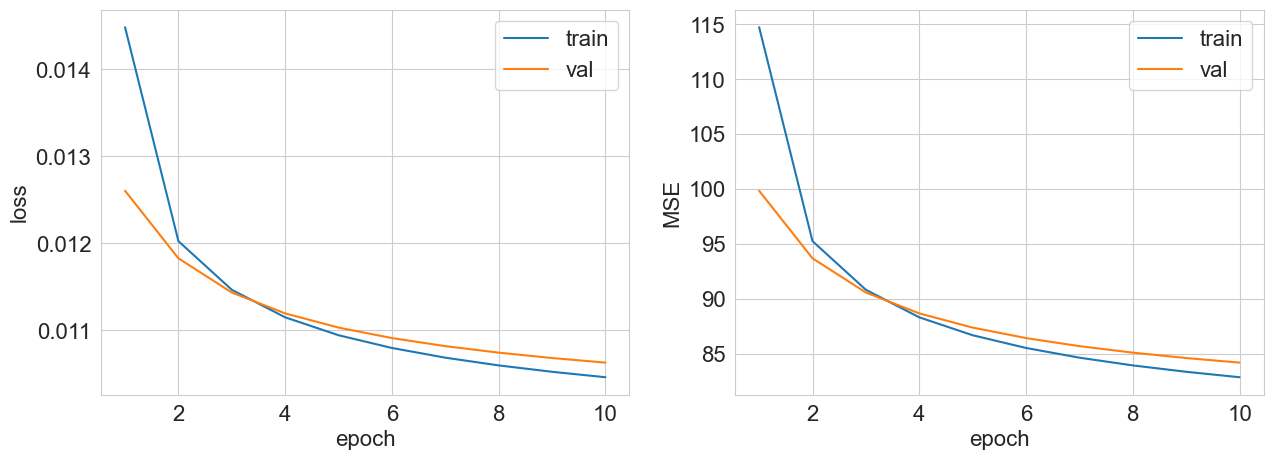

Validation MSE: 84.203


(82.87332067076711, 84.20299201547728)

In [26]:
model = InitialModel_MSE_norm()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.3, lr=0.01, fused=True)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10
)

In [27]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

MSE: 81.714


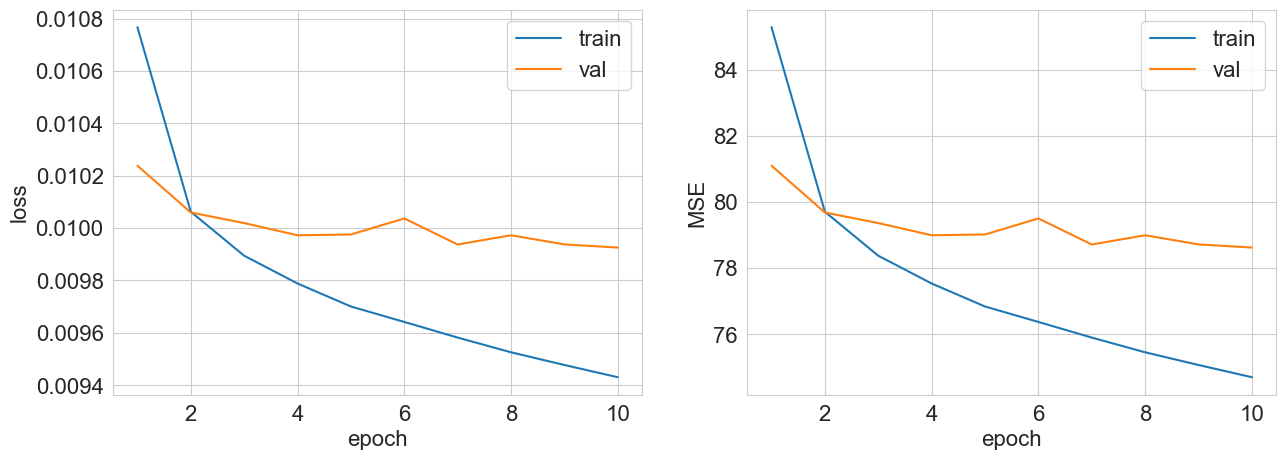

Validation MSE: 78.622


(74.70013253920692, 78.62198175804575)

In [29]:
model = InitialModel_MSE_norm()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1.5e-3, fused=True)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10
)

In [30]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

MSE: 78.464


> Видимо, задача не слишком сложная, и все оптимизаторы справляются с ней достаточно хорошо  
По идее Adam должен быть получше SGD+momentum

**Задание 2.2 (1 балл).** Теперь сделаем нашу нейронную сеть более сложной. Попробуйте сделать сеть:

- более широкой (то есть увеличить размерность скрытого слоя, например, вдвое)
- более глубокой (то есть добавить еще один скрытый слой)

Опишите, как увеличение числа параметров модели влияет на качество на обучающей и валидационной выборках.

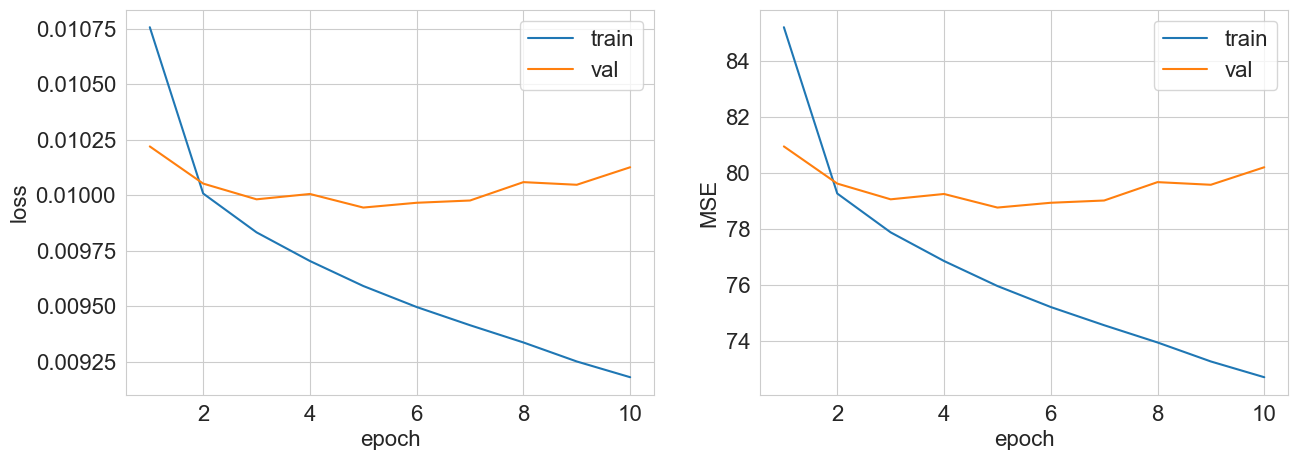

Validation MSE: 80.205


(72.70933195749326, 80.20494013530327)

In [36]:
class yet_another_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=256)
        self.af1 = nn.ReLU()
        self.l2 = nn.LazyLinear(out_features=1)
        self.af2 = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.af1(pred)
        pred = self.l2(pred)
        pred = self.af2(pred)

        return pred

model = yet_another_model()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10
)

In [37]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

MSE: 80.175


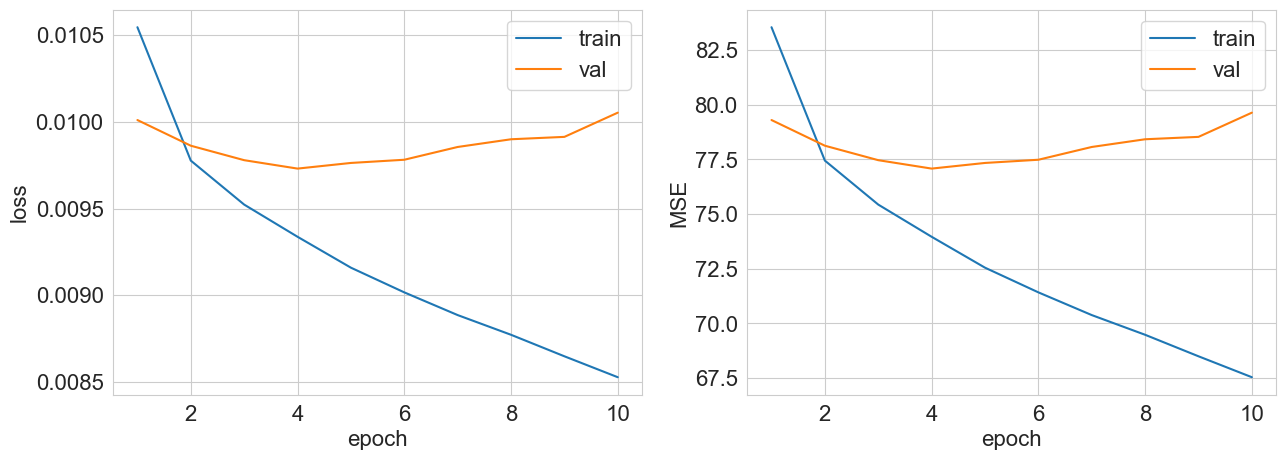

Validation MSE: 79.629


(67.54153903904583, 79.62923234674693)

In [38]:
class yet_another_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=128)
        self.af1 = nn.ReLU()
        self.l2 = nn.LazyLinear(out_features=128)
        self.af2 = nn.ReLU()
        self.l3 = nn.LazyLinear(out_features=1)
        self.af3 = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.af1(pred)
        pred = self.l2(pred)
        pred = self.af2(pred)
        pred = self.l3(pred)
        pred = self.af3(pred)

        return pred

model = yet_another_model()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10
)

In [ ]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

> Постепенно ошибка на train продолжает падать, а на eval начинает расти, т.е. модель постепенно переобучается

**Задание 2.3 (1 балл).** Как вы должны были заметить, более сложная модель стала сильнее переобучаться. Попробуем добавить в обучение регуляризацию, чтобы бороться с переобучением. Добавьте слой дропаута ([`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)) с параметром $p=0.2$ после каждого линейного слоя, кроме последнего. Почитать про дропаут можете в следующем [блогпосте](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) или в оригинальной [статье](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

Опишите результаты. 

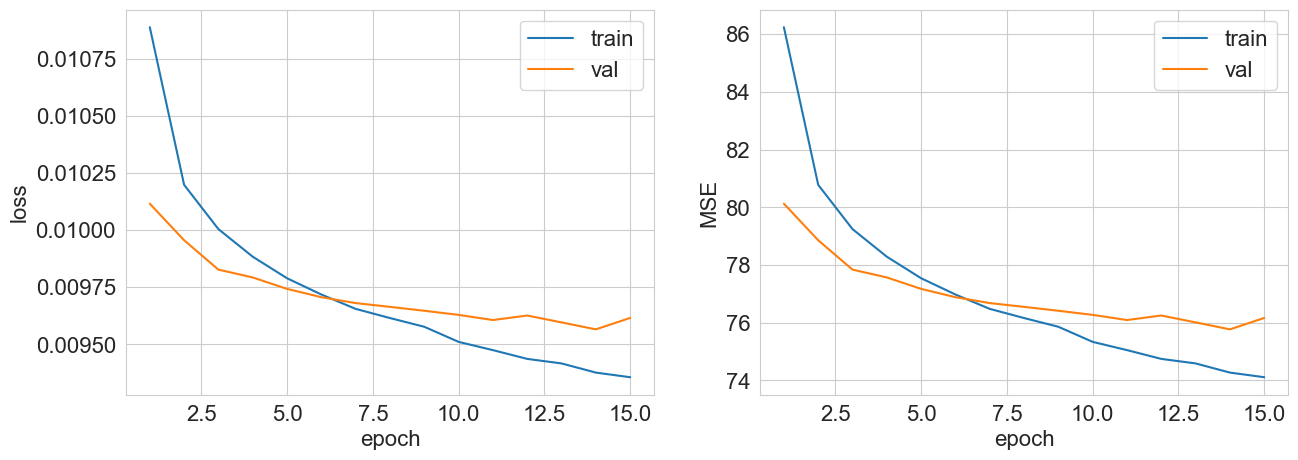

Validation MSE: 76.162


(74.10599414838428, 76.16180211423622)

In [39]:
class yet_another_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.l1 = nn.LazyLinear(out_features=128)
        self.do1 = nn.Dropout(p=0.2)
        self.af1 = nn.ReLU()

        self.l2 = nn.LazyLinear(out_features=128)
        self.do2 = nn.Dropout(p=0.2)
        self.af2 = nn.ReLU()

        self.l3 = nn.LazyLinear(out_features=1)
        self.af3 = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        pred = self.l1(x)
        pred = self.do1(pred)
        pred = self.af1(pred)

        pred = self.l2(pred)
        pred = self.do2(pred)
        pred = self.af2(pred)

        pred = self.l3(pred)
        pred = self.af3(pred)

        return pred

model = yet_another_model()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

val_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)


train_and_validate_norm(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=15
)

In [40]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

MSE: 75.820


> Моделька с dropout намного стабильнее: ошибки на train и val идут рядом друг с дружкой, и постепенно модель сходится

**Задание 2.4 (1.5 балла).** Теперь, когда мы определились с выбором архитектуры нейронной сети, пора заняться рутиной DL-инженера &mdash; перебором гиперпараметров. Подберите оптимальное значение lr по значению MSE на валидации (по логарифмической сетке, достаточно посмотреть 3-4 значения), можете воспользоваться `verbose=False` в функции `train_and_validate`.

Также подберем оптимальное значение параметра weight decay для данного lr. Weight decay &mdash; это аналог L2-регуляризации для нейронных сетей. Почитать о нем можно, например, [здесь](https://paperswithcode.com/method/weight-decay). В PyTorch он задается как параметр оптимизатора `weight_decay`. Подберите оптимальное значение weight decay по логарифимической сетке (его типичные значения лежат в диапазоне $[10^{-6}, 10^{-3}]$, но не забудьте включить нулевое значение в сетку).

Постройте графики зависимости MSE на трейне и на валидации от значений параметров. Прокомментируйте получившиеся зависимости.

In [ ]:
def run_optim(
    lr: float,
    wd: float
):
    model = yet_another_model()
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=lr, weight_decay=wd, fused=True)

    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1),
    ), batch_size=32)

    val_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1),
    ), batch_size=32)

    _, val_metrics = train_and_validate_norm(
        model=model,
        optimizer=optimizer,
        criterion=nn.MSELoss(),
        metric=nn.MSELoss(),
        train_loader=train_dataloader,
        val_loader=val_dataloader,
        num_epochs=10,
        verbose=False
    )

    print(f"LR: {lr:.0e}, WD: {wd:.0e}, MSE val: {val_metrics:.3f}")

lr_list = np.logspace(-4, -1, base=10, num=4, endpoint=True)
wd_list = np.logspace(-6, -3, base=10, num=4, endpoint=True)

In [42]:
# Буду перебирать отдельно learning rate и weight decay

for lr in lr_list:
    run_optim(lr, 0)

LR: 1e-04, WD: 0e+00, MSE val: 76.627
LR: 1e-03, WD: 0e+00, MSE val: 76.690
LR: 1e-02, WD: 0e+00, MSE val: 83.289
LR: 1e-01, WD: 0e+00, MSE val: 280.064


> При больших learning rate модель не сходится к точке оптимума, при малых - не успевает за отведенное число эпох

In [44]:
# возьмем лучший lr, будем перебирать ненулевые wd (wd=0 был в предыдущих прогонах)

for wd in wd_list:
    run_optim(1e-04, wd)

LR: 1e-04, WD: 1e-06, MSE val: 76.372
LR: 1e-04, WD: 1e-05, MSE val: 76.577
LR: 1e-04, WD: 1e-04, MSE val: 78.477
LR: 1e-04, WD: 1e-03, MSE val: 83.875


> С weight decay = 10^(-6) стало чуть лучше, хотя мне кажется эффекта от dropout вполне достаточно

Как вы могли заметить, еще одна рутина DL-инженера &mdash; утомительное ожидание обучения моделей.

**Задание 2.5 (0.5 балла).** Мы провели большое число экспериментов и подобрали оптимальную архитектуру и гиперпараметры. Пришло время обучить модель на полной обучающей выборке, померять качество на тестовой выборке и сравнить с бейзлайнами. Проделайте это. 

In [53]:
def train_final(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion,
    metric,
    train_loader,
    num_epochs,
    verbose=True,
):
    train_metrics = []

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_batch_norm = normalize(y_batch)

            predictions: torch.Tensor = model(X_batch)
            loss = criterion(predictions, y_batch_norm)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.no_grad():
                metric_value = metric(denormalize(predictions), y_batch)
                if isinstance(metric_value, torch.Tensor):
                    metric_value = metric_value.item()                
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_metrics += [running_metric / len(train_loader.dataset)]

    if verbose:
        print(f"Train MSE: {train_metrics[-1]:.3f}")


model = yet_another_model()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-04, weight_decay=1e-06, fused=True)

train_dataloader = DataLoader(TensorDataset(
    torch.tensor(np.concat([X_train_scaled, X_val_scaled]), dtype=torch.float32),
    torch.tensor(np.concat([y_train, y_val]), dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

test_dataloader = DataLoader(TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1),
), batch_size=32)

train_final(
    model=model,
    optimizer=optimizer,
    criterion=nn.MSELoss(),
    metric=nn.MSELoss(),
    train_loader=train_dataloader,
    num_epochs=15
)

Training 1/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 2/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 3/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 4/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 5/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 6/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 7/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 8/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 9/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 10/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 11/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 12/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 13/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 14/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Training 15/15:   0%|          | 0/12079 [00:00<?, ?it/s]

Train MSE: 74.036


In [55]:
pred, real = get_predictions(model, test_dataloader)
mse = nn.functional.mse_loss(denormalize(torch.tensor(pred).to(device)), torch.tensor(real).to(device).reshape(-1, 1)).to("cpu").numpy()
print(f"MSE: {mse:.3f}")

MSE: 74.944


> MSE (test): 74.944

Результаты лучше, чем у Baseline